In [1]:
#import required packages to explore the data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import statsmodels.api as sm


__Data source: ProFootballReference.com__

In [2]:
#import ProFootball Reference Player Stats
RPSData = pd.read_csv(r"C:\Users\PFR_HistoricalStats.csv")

In [3]:
#View a sample of the data
RPSData.head()

,Player,Year,Tm,FantPos,Age,G,GS,Cmp,Pass_Att,Yds_G_Pass,...,Tot_TD,2PM,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank
0,Todd Gurley,2017,LAR,RB,23,15,15,0,0,0,...,19,NaN,NaN,319.0,383.3,391.3,351.3,192.0,1,1.0
1,Le'Veon Bell,2017,PIT,RB,25,15,15,0,0,0,...,11,NaN,NaN,257.0,341.6,349.6,299.1,130.0,2,2.0
2,Alvin Kamara,2017,NOR,RB,22,16,3,0,0,0,...,14,1.0,NaN,239.0,320.4,327.4,279.9,112.0,4,4.0
3,Kareem Hunt,2017,KAN,RB,22,16,16,0,0,0,...,11,NaN,NaN,242.0,295.2,302.2,268.7,115.0,3,3.0
4,Melvin Gordon,2017,LAC,RB,24,16,16,0,0,0,...,12,NaN,NaN,230.0,288.1,294.1,259.1,103.0,5,5.0


## Prepare Data for training and testing

In [4]:
#Filter table to view only stats and fantasy points related to NFL Running Backs
RPSData = RPSData.loc[RPSData['FantPos'] == 'RB', ['Player', 'Year', 'FantPos', 'Age', 'G', 'GS', 'Rush_Att', 'Rush_Yds_G', 'Y/A', 'Rush_TD', 'Tgt', 'Rec', 'Rec_Yds', 'Y/R', 'Rec_TD', 'Tot_TD', 'FantPt', 'PPR']]

#Replace NANs with 0
RPSData['Y/A'] = pd.to_numeric(RPSData['Y/A'], errors = 'coerce')
RPSData['Y/A'] = RPSData['Y/A'].replace(np.nan, 0)

RPSData['Y/R'] = pd.to_numeric(RPSData['Y/R'], errors = 'coerce')
RPSData['Y/R'] = RPSData['Y/R'].replace(np.nan,0)

RPSData['PPR'] = pd.to_numeric(RPSData['PPR'], errors = 'coerce')
RPSData['PPR'] = RPSData['PPR'].replace(np.nan,0)


In [5]:
RPSData.head(10)

,Player,Year,FantPos,Age,G,GS,Rush_Att,Rush_Yds_G,Y/A,Rush_TD,Tgt,Rec,Rec_Yds,Y/R,Rec_TD,Tot_TD,FantPt,PPR
0,Todd Gurley,2017,RB,23,15,15,279,1305,4.68,13,87,64,788,12.31,6,19,319.0,383.3
1,Le'Veon Bell,2017,RB,25,15,15,321,1291,4.02,9,106,85,655,7.71,2,11,257.0,341.6
2,Alvin Kamara,2017,RB,22,16,3,120,728,6.07,8,100,81,826,10.20,5,14,239.0,320.4
3,Kareem Hunt,2017,RB,22,16,16,272,1327,4.88,8,63,53,455,8.58,3,11,242.0,295.2
4,Melvin Gordon,2017,RB,24,16,16,284,1105,3.89,8,83,58,476,8.21,4,12,230.0,288.1
5,Mark Ingram,2017,RB,28,16,12,230,1124,4.89,12,71,58,416,7.17,0,12,220.0,278.0
6,LeSean McCoy,2017,RB,29,16,16,287,1138,3.97,6,77,59,448,7.59,2,8,205.0,263.6
7,Carlos Hyde,2017,RB,27,16,16,240,938,3.91,8,88,59,350,5.93,0,8,175.0,233.8
8,Leonard Fournette,2017,RB,22,13,13,268,1040,3.88,9,48,36,302,8.39,1,10,194.0,230.2
9,Christian McCaffrey,2017,RB,21,16,10,117,435,3.72,2,113,80,651,8.14,5,7,149.0,228.6


In [6]:
# Add columns to score a running backs usage. 
# "Utilization1" adds rushing attempts and targets together. "Utilization2" adds rushing attempts, targets, receptions.
RPSData['Utilization1'] = RPSData['Rush_Att'] + RPSData['Tgt']
RPSData['Utilization2'] = RPSData['Rush_Att'] + RPSData['Tgt'] + RPSData['Rec']
RPSData['Efficiency'] = RPSData['Y/A'] + RPSData['Y/R']

#RPSData = RPSData.sort_values(['Utilization2'], ascending = [False])
RPSData = RPSData.sort_values(['Year'], ascending = [False])
#RPSData = RPSData.sort_values(['PPR'], ascending = [False])

In [7]:
RPSData.head()

,Player,Year,FantPos,Age,G,GS,Rush_Att,Rush_Yds_G,Y/A,Rush_TD,...,Rec,Rec_Yds,Y/R,Rec_TD,Tot_TD,FantPt,PPR,Utilization1,Utilization2,Efficiency
2436,Adrian Killins,2020,RB,22,1,0,1,-12,-12.00,0,...,1,2,2.00,0,0,-1.0,0.0,2,3,-10.00
2026,Le'Veon Bell,2020,RB,28,11,4,82,328,4.00,2,...,16,138,8.63,0,2,59.0,74.6,102,118,12.63
2011,Benny Snell Jr.,2020,RB,22,16,3,111,368,3.32,4,...,10,61,6.10,0,4,65.0,74.9,125,135,9.42
2009,Kalen Ballage,2020,RB,25,11,2,91,303,3.33,3,...,29,166,5.72,0,3,65.0,93.9,128,157,9.05
2007,James White,2020,RB,28,14,0,35,121,3.46,2,...,49,375,7.65,1,3,68.0,116.6,97,146,11.11


# Exploratory Data Analysis

### Relationship between a running back's utilization and Fantasy PPR Points.

Text(0.5, 1.0, 'Utilization1 vs. PPR')

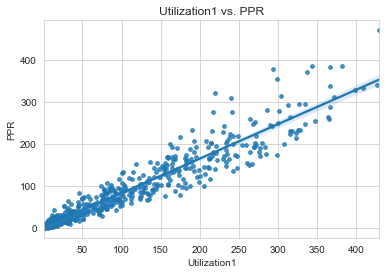

In [9]:
sns.set_style('whitegrid')
#sns.set(color_codes = True)
sns.regplot(x = 'Utilization1', y = 'PPR', data = RPSData, scatter_kws={'s':14})
plt.title('Utilization1 vs. PPR')

In [10]:
X = RPSData['Utilization1']
y = RPSData['PPR']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     6426.
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:55:40   Log-Likelihood:                -2870.2
No. Observations:                 619   AIC:                             5744.
Df Residuals:                     617   BIC:                             5753.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4081      1.402      0.291   

Text(0.5, 1.0, 'Utilization2 vs PPR')

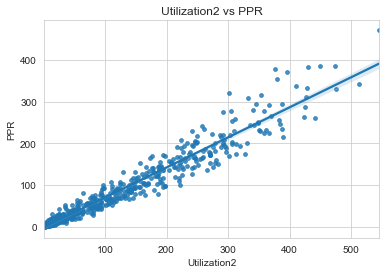

In [11]:
sns.set_style('whitegrid')
#sns.set_style('ticks')

sns.regplot(x = 'Utilization2', y = 'PPR', data = RPSData, scatter_kws={'s':14})
plt.title('Utilization2 vs PPR')


In [12]:
X = RPSData['Utilization2']
y = RPSData['PPR']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                 1.057e+04
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:55:41   Log-Likelihood:                -2726.9
No. Observations:                 619   AIC:                             5458.
Df Residuals:                     617   BIC:                             5467.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.4528      1.122     -2.185   

__The R-Squared value above, indicates a player's utilization will be a strong predictive variable for determining Fantasy points.__

### Relationship between a running back's Efficiency and Fantasy PPR Points.

Text(0.5, 1.0, 'Efficiency vs PPR')

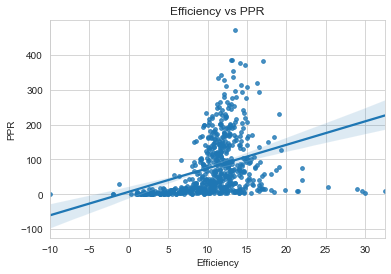

In [13]:
sns.regplot(x = 'Efficiency', y = 'PPR', data = RPSData, scatter_kws={'s':14})
plt.title('Efficiency vs PPR')

In [14]:
X = RPSData['Efficiency']
y = RPSData['PPR']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     84.06
Date:                Wed, 14 Apr 2021   Prob (F-statistic):           7.08e-19
Time:                        11:55:41   Log-Likelihood:                -3584.3
No. Observations:                 619   AIC:                             7173.
Df Residuals:                     617   BIC:                             7181.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7925      8.468      0.802      0.4

Text(0.5, 1.0, 'Rushing Yards/Attempt vs PPR')

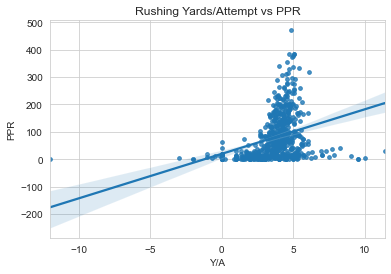

In [15]:
sns.regplot(x = 'Y/A', y = 'PPR', data = RPSData, scatter_kws={'s':14})
plt.title('Rushing Yards/Attempt vs PPR')

In [16]:
X = RPSData['Y/A']
y = RPSData['PPR']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     81.70
Date:                Wed, 14 Apr 2021   Prob (F-statistic):           2.02e-18
Time:                        11:55:41   Log-Likelihood:                -3585.3
No. Observations:                 619   AIC:                             7175.
Df Residuals:                     617   BIC:                             7183.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.8015      7.258      2.728      0.0

Text(0.5, 1.0, 'Receiving Yards/Reception vs PPR')

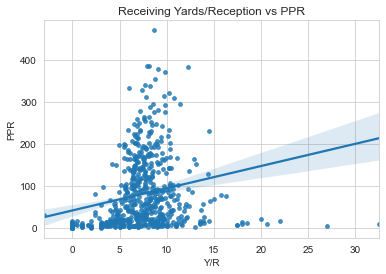

In [17]:
sns.regplot(x = 'Y/R', y = 'PPR', data = RPSData, scatter_kws={'s':14})
plt.title('Receiving Yards/Reception vs PPR')

In [18]:
X = RPSData['Y/R']
y = RPSData['PPR']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    PPR   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     36.65
Date:                Wed, 14 Apr 2021   Prob (F-statistic):           2.46e-09
Time:                        11:55:42   Log-Likelihood:                -3605.9
No. Observations:                 619   AIC:                             7216.
Df Residuals:                     617   BIC:                             7225.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.4364      6.988      5.930      0.0

__The R-Squared values above, indicate player efficiency, rushing yards per attempt and receiving yards per reception would not be good predictive variables for determining if a running back will score many Fantasy points.__

### Age Distribution of NFL Running Backs

Text(0.5, 1.0, 'Age Distribution of Running Backs')

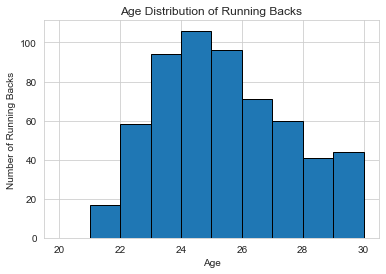

In [19]:
#RPSData.plot(x = 'Age', y = 'FantPt', kind = 'bar')

plt.hist(RPSData['Age'], bins=[20,21,22,23,24,25,26,27,28,29,30], edgecolor = 'black')
plt.xlabel ('Age')
plt.ylabel ('Number of Running Backs')
plt.title ('Age Distribution of Running Backs')

### Age Distribution of Top 15 NFL Running Backs Based on Fantasy PPR Points.

In [20]:
#import ProFootball Reference Player Stats
PeakAgeDf = pd.read_csv(r"C:\Users\Hist_Top15RB.csv")

Text(0.5, 1.0, 'Age Distribution of Top 15 Running Backs from 2017-2019 (PPR)')

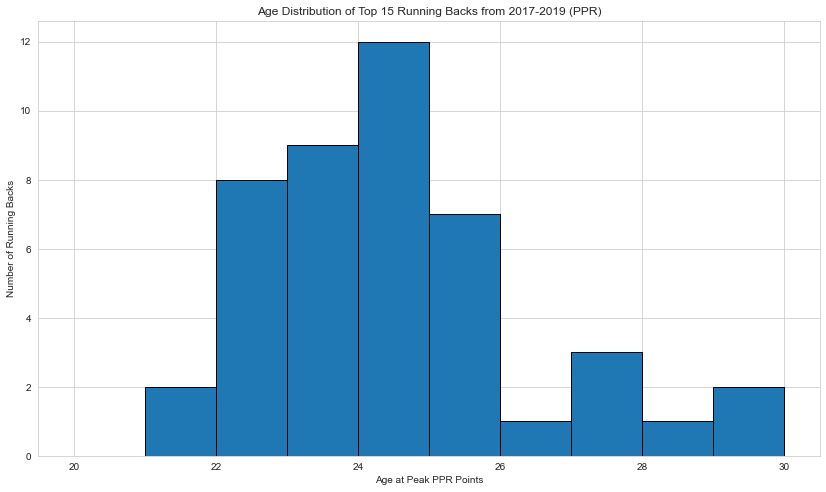

In [21]:
plt.figure(figsize = (14,8))
plt.hist(PeakAgeDf['Age'], bins=[20,21,22,23,24,25,26,27,28,29,30], edgecolor = 'black')
plt.xlabel ('Age at Peak PPR Points')
plt.ylabel ('Number of Running Backs')
plt.title ('Age Distribution of Top 15 Running Backs from 2017-2019 (PPR)')

__The top 15 Running Backs scored the most fantasy PPR points between the ages of 23-25 and start to decline in performance beginning at age 26.__

# Supervised Model

### Linear Regression

In [22]:
#Split data into training set based on 2017 to 2019 data and testing set using 2020 data.
testData = RPSData.iloc[:163,:]
trainData = RPSData.iloc[164:,:]


In [23]:
# Define variables
x_train = trainData['Utilization2']
y_train = trainData['PPR']
x_test = testData['Utilization2']
y_test = testData['PPR']
target = testData['PPR']

In [24]:
print(x_train.shape, x_test.shape,y_train.shape,y_test.shape)

(455,) (163,) (455,) (163,)


In [25]:
x_train

1723    122
1722     92
1721     84
1720    118
1719     93
       ... 
101      18
100      22
99       28
98       56
0       430
Name: Utilization2, Length: 455, dtype: int64

In [26]:
# Choose model
model = LinearRegression()

In [27]:
#fit model
model.fit(x_train.values.reshape(-1,1) ,y_train.values.reshape(-1,1))

LinearRegression()

In [28]:
# Predict
PPR_Pred = model.predict(x_test.values.reshape(-1,1))

In [29]:
y_test

2436      0.0
2026     74.6
2011     74.9
2009     93.9
2007    116.6
        ...  
2203     16.2
2200     20.2
2197     26.1
2211     28.2
2195     16.7
Name: PPR, Length: 163, dtype: float64

In [30]:
#Score the model
model.score(x_test.values.reshape(-1,1),y_test.values.reshape(-1,1))

0.9551719317710933

In [31]:
df_lreg = pd.DataFrame({'Actual PPR Points': y_test.values.flatten(), 'Predicted PPR Points': PPR_Pred.flatten()})
df_lreg.head()

,Actual PPR Points,Predicted PPR Points
0,0.0,-0.248603
1,74.6,82.109672
2,74.9,94.284373
3,93.9,110.039869
4,116.6,102.162121


In [32]:
#Join results with the original data frame to rank the best players based on the model.
df_og_results = pd.concat([RPSData.reset_index(drop=True), pd.DataFrame(df_lreg)], axis = 1)
df_og_results.columns.values[-2: ] = ['Actual PPR Points', 'Predicted PPR Points']

In [33]:
df_og_results.head()

,Player,Year,FantPos,Age,G,GS,Rush_Att,Rush_Yds_G,Y/A,Rush_TD,...,Y/R,Rec_TD,Tot_TD,FantPt,PPR,Utilization1,Utilization2,Efficiency,Actual PPR Points,Predicted PPR Points
0,Adrian Killins,2020,RB,22,1,0,1,-12,-12.00,0,...,2.00,0,0,-1.0,0.0,2,3,-10.00,0.0,-0.248603
1,Le'Veon Bell,2020,RB,28,11,4,82,328,4.00,2,...,8.63,0,2,59.0,74.6,102,118,12.63,74.6,82.109672
2,Benny Snell Jr.,2020,RB,22,16,3,111,368,3.32,4,...,6.10,0,4,65.0,74.9,125,135,9.42,74.9,94.284373
3,Kalen Ballage,2020,RB,25,11,2,91,303,3.33,3,...,5.72,0,3,65.0,93.9,128,157,9.05,93.9,110.039869
4,James White,2020,RB,28,14,0,35,121,3.46,2,...,7.65,1,3,68.0,116.6,97,146,11.11,116.6,102.162121


In [34]:
#Export Results to excel to view individual player ranks
df_og_results.to_excel (r'C:\Users\RB_LG_PredModel.xlsx', index = False, header = True)

## Visualize Model Results

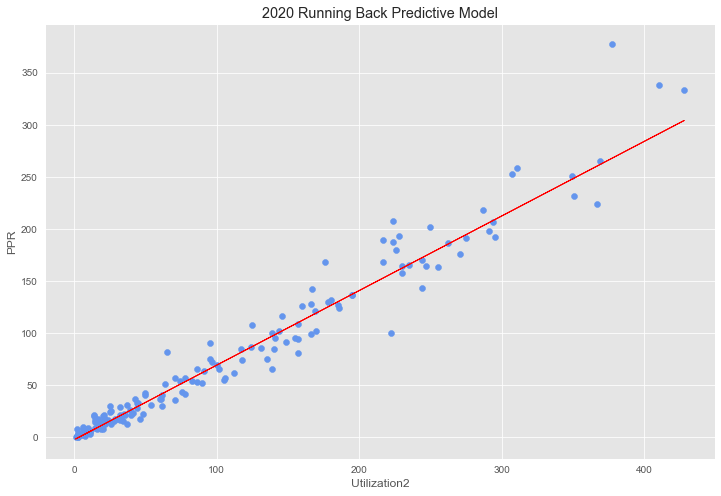

In [35]:
plt.figure(figsize = (12,8))
plt.style.use('ggplot')
plt.scatter(x_test, y_test,  color = 'cornflowerblue')
plt.plot(x_test, PPR_Pred, color = 'red', linewidth = 1)

#style the plo
plt.title('2020 Running Back Predictive Model')
plt.xlabel('Utilization2')
plt.ylabel('PPR')
plt.show()

# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         ax.text(point['x']+.02, point['y'], str(point['val']))

# label_point(RPSData.Utilization2, RPSData.PPR, RPSData.Player, plt.gca())


## Test the Performance of the Model

In [36]:
metrics.r2_score(x_test,PPR_Pred)

0.8244608882741962

In [37]:
metrics.mean_squared_error(y_test, PPR_Pred)
np.sqrt(metrics.mean_squared_error(y_test, PPR_Pred))

16.70428262956451

__The model is approximately 82 % accurate at predicting the PPR fantasy points NFL Running Backs will score in a season based on player utilization inputs.  The error margin is within approximately 17 fantasy PPR points.  This model does not account for negative statistics such as fumbles and fails to account for player injuries.  Therefore domain knowledge is crucial as injured players will have artificially low fantasy points (eg. Christian McCaffry's 2020 season).  While an exploratory analysis of the peak scoring age of the top 15 running backs was performed, it was not included in the model and should be taken into account when assessing an individual running back's performance in the upcoming season.__ 